In [1]:
import pandas as pd
import numpy as np
import sys
from pyspark.sql import functions as f
import re
from functools import reduce
from pyspark.sql import SparkSession
from typing import Dict
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType, FloatType
from pandas.tseries.offsets import MonthEnd
from datetime import datetime
import re
from pyspark.sql.window import Window
import plotly.express as px
from pyspark.ml.feature import Bucketizer
from itertools import chain
from pandas.tseries.offsets import MonthEnd
from dateutil.relativedelta import relativedelta
pd.set_option('display.max_columns', 200)

In [2]:
#!pip install scikit-learn --force
#!pip install catboost
#!pip install ipywidgets --force

In [3]:
price_res = pd.read_parquet('price_res.parquet')

In [4]:
share_res = pd.read_parquet('s_share_res.parquet')

In [5]:
res = share_res[share_res['train_flg'] == False].merge(price_res[price_res['train_flg'] == False].rename(columns = {'fact_ln': 'fact_price', 'pred_ln': 'pred_price'}), on = ['report_date', 'object', 'step']).sort_values('report_date')\
        .groupby(['object', 'step']).apply(lambda df: df.assign(
    escrow_volume_new = (pd.concat([df['S_share_shift'].iloc[[0]], df['S_share']]).diff().dropna()*df['mean_price_per_metr']*df['S']).cumsum() + df['escrow_volume_shift'].iloc[0],
    
    escrow_volume_pred = (pd.concat([df['S_share_shift'].iloc[[0]], df['pred_share']]).diff().dropna()*df['pred_price']*df['S']).cumsum() + df['escrow_volume_shift'].iloc[0])
                                          )

In [6]:
res

,report_date,object,fact_x,fact_share,pred_share,pred_x,step,train_flg_x,escrow_volume,mean_price_per_metr,S_share,S,S_inflow,S_share_shift,escrow_volume_shift,fact_y,pred_y,fact_price,pred_price,train_flg_y,escrow_volume_new,escrow_volume_pred
0,2022-10-31,43553.0,488.00,0.555556,0.506524,444.930487,1,False,2.142558e+07,39271.722441,0.555556,878.40,0.00,0.555556,2.142558e+07,inf,inf,39271.722441,43800.000214,False,2.142558e+07,1.953913e+07
301,2022-10-31,42313.0,7653.67,0.761029,0.770630,7750.226002,1,False,8.222092e+08,126873.050405,0.761029,10057.00,298.78,0.731320,7.843021e+08,inf,inf,126873.050405,151851.474176,False,8.222092e+08,8.443344e+08
300,2022-10-31,40083.0,957.11,0.264030,0.016788,60.855798,1,False,1.063948e+08,111162.562297,0.264030,3625.00,957.11,0.000000,0.000000e+00,inf,inf,111162.562297,153757.753303,False,1.063948e+08,9.357051e+06
299,2022-10-31,42314.0,6587.94,0.729181,0.768338,6941.714421,1,False,6.408877e+08,130109.683865,0.729181,9034.71,140.13,0.713671,6.226554e+08,inf,inf,130109.683865,137117.436348,False,6.408877e+08,6.903783e+08
298,2022-10-31,44842.0,0.00,0.000000,0.000000,0.000000,1,False,0.000000e+00,0.000000,0.000000,14615.39,0.00,0.000000,0.000000e+00,inf,inf,120460.668956,174672.186022,False,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4968,2023-12-31,44069.0,30386.60,1.000000,0.987806,30016.055961,5,False,4.719865e+09,240901.781882,1.000000,30386.60,71.20,0.997657,4.702713e+09,inf,inf,240901.781882,163281.955591,False,4.719865e+09,4.615246e+09
4969,2023-12-31,40019.0,9233.49,0.911800,0.984624,9970.953178,5,False,8.506758e+08,112417.295728,0.911800,10126.66,192.88,0.892753,8.289928e+08,inf,inf,112417.295728,113297.874826,False,8.506758e+08,9.302492e+08
4970,2023-12-31,44826.0,3131.18,0.680333,0.766607,3528.247140,5,False,4.008311e+08,122040.229885,0.680333,4602.42,17.40,0.676553,3.987076e+08,inf,inf,122040.229885,143650.001038,False,4.008311e+08,4.589630e+08
4958,2023-12-31,46138.0,30283.10,0.812271,0.794348,29614.894756,5,False,1.001182e+10,353267.681817,0.812271,37282.00,2214.60,0.752870,9.229472e+09,inf,inf,353267.681817,368171.020025,False,1.001182e+10,9.764495e+09


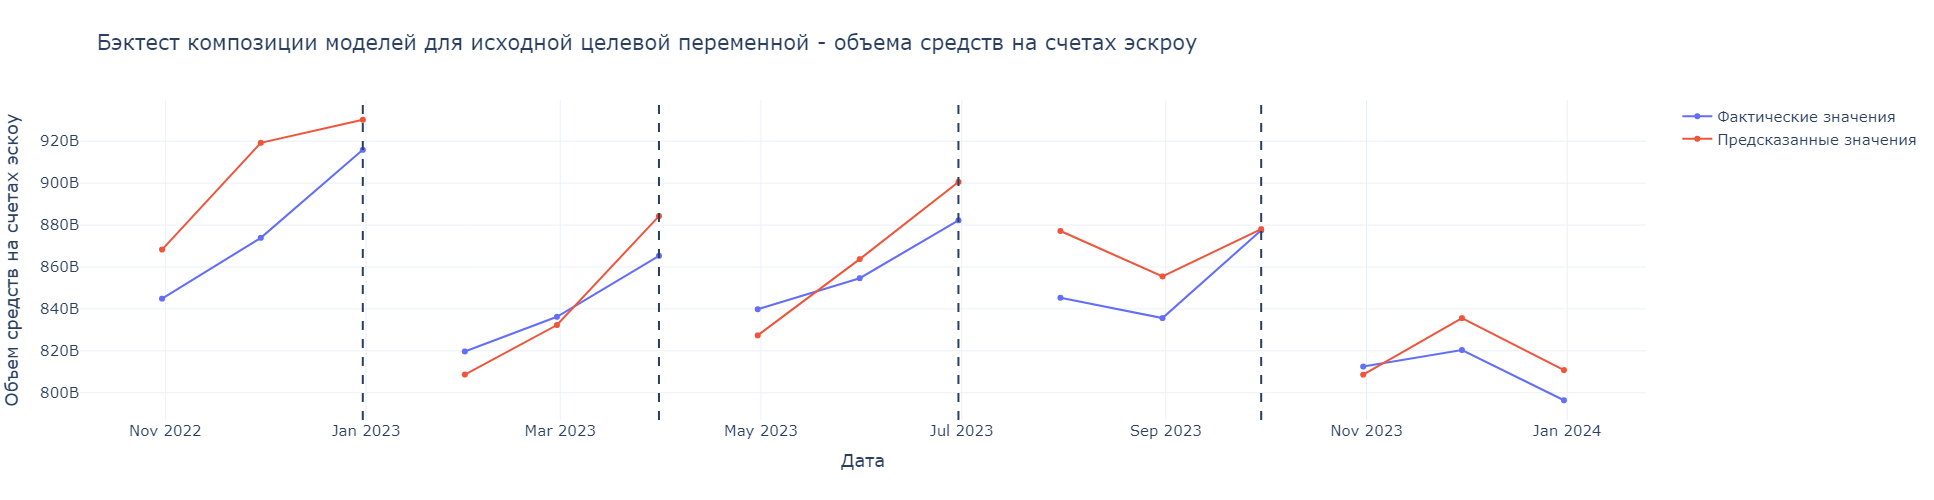

In [10]:
import plotly.io as pio
pio.templates.default = 'plotly_white'

fig = px.line(res.groupby('report_date').agg({'step': 'first', 'escrow_volume': 'sum', 'escrow_volume_pred': 'sum'}).rename(columns = {'escrow_volume_pred': 'Предсказанные значения', 'escrow_volume': 'Фактические значения'}),
              title = 'Бэктест композиции моделей для исходной целевой переменной - объема средств на счетах эскроу', line_group = 'step', markers = True, height = 500)

for dt in res.groupby('step').agg({'report_date': 'max'})['report_date'].values[:-1]:
    fig.add_vline(x = pd.to_datetime(dt), line_dash = 'dash')
fig.update_layout(font = dict(size = 15), xaxis_title = 'Дата', yaxis_title = 'Объем средств на счетах эскоу', legend_title = '')

In [17]:
from sklearn.metrics import mean_absolute_error as mae, mean_absolute_percentage_error as mape

agg_res = res.groupby(['step', 'report_date'], as_index = False).agg({'escrow_volume': 'sum', 'escrow_volume_new': 'sum', 'escrow_volume_pred': 'sum'})

mae(agg_res['escrow_volume_new'], agg_res['escrow_volume_pred'])/10**9

16.182250124386197

In [22]:
agg_res.groupby(['step']).apply(lambda df: pd.Series({'mae': mae(df['escrow_volume'], df['escrow_volume_pred'])})) / 10**9

,mae
step,
1,27.707599
2,11.302737
3,13.310733
4,17.431146
5,11.159036


In [26]:
agg_res.groupby(['step']).apply(lambda df: pd.Series({'mape': mape(df['escrow_volume'], df['escrow_volume_pred'])})) 

,mape
step,
1,0.031761
2,0.013351
3,0.015437
4,0.020704
5,0.013793


In [27]:
mae(agg_res['escrow_volume'], agg_res['escrow_volume_pred'])/10**9, mape(agg_res['escrow_volume'], agg_res['escrow_volume_pred'])

(16.182250124386204, 0.01900919311926386)